In [1]:
!pip install transformers
!pip install sentencepiece
!pip3 install mvlearn
!pip install POT

from google.colab import drive
drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 13.3 MB/s 
     |████████████████████████████████| 101 kB 15.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.0 MB/s 
     |████████████████████████████████| 596 kB 71.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 17.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 14.3 MB/s 
     |████████████████████████████████| 38.1 MB 349 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
import os
os.chdir('drive/MyDrive/William_2022/DATASETS/main_trans_ZuCo_sent')

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from model_new import Transformer, Transformer2, Encoder
from config import *
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from tqdm import tqdm
from optim_new import ScheduledOptim
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
from CCA import DeepCCA, cca_loss
from scipy.stats import wasserstein_distance
from mvlearn.embed import DCCA
from mvlearn.datasets import make_gaussian_mixture
from mvlearn.plotting import crossviews_plot
from dataset_new import Fusion
import matplotlib.pylab as pl
import ot
import ot.plot
from mvlearn.plotting import quick_visualize
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns

In [16]:
# --- load ZuCo sentence

#normal

X_val_text = np.loadtxt('baselines/text/sentiment_baseline_onlytext_all_pred_val.txt')
X_test_text = np.loadtxt('baselines/text/sentiment_baseline_onlytext_all_pred.txt')

y_val_text = np.loadtxt('baselines/text/sentiment_baseline_onlytext_all_label_val.txt')
y_test_text = np.loadtxt('baselines/text/sentiment_baseline_onlytext_all_label.txt')

X_val_eeg = np.loadtxt('baselines/eeg/sentiment_baseline_onlyeeg_all_pred_val.txt')
X_test_eeg = np.loadtxt('baselines/eeg/sentiment_baseline_onlyeeg_all_pred.txt')

y_val_eeg = np.loadtxt('baselines/eeg/sentiment_baseline_onlyeeg_all_label_val.txt')
y_test_eeg = np.loadtxt('baselines/eeg/sentiment_baseline_onlyeeg_all_label.txt')

#fusion

X_val_fusion = np.loadtxt('baselines/text_eeg_fusion/sentiment_baseline_fusion_linout_all_pred_val.txt')
X_test_fusion = np.loadtxt('baselines/text_eeg_fusion/sentiment_baseline_fusion_linout_all_pred.txt')

y_val_fusion = np.loadtxt('baselines/text_eeg_fusion/sentiment_baseline_fusion_linout_all_label_val.txt')
y_test_fusion = np.loadtxt('baselines/text_eeg_fusion/sentiment_baseline_fusion_linout_all_label.txt')

#DCCA

X_val_DCCA_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred_val.txt')
X_test_DCCA_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred_test.txt')

X_val_DCCA_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred2_val.txt')
X_test_DCCA_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred2_test.txt')

y_val_DCCA = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_label_val.txt')
y_test_DCCA = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_label_test.txt')

#DCCA fusion

X_val_DCCA_fusion = np.loadtxt('baselines/DCCA_fusion/sentiment_baseline_DCCA_fusion_trans_all_pred_val.txt')
X_test_DCCA_fusion = np.loadtxt('baselines/DCCA_fusion/sentiment_baseline_DCCA_fusion_trans_all_pred.txt')

y_val_DCCA_fusion = np.loadtxt('baselines/DCCA_fusion/sentiment_baseline_DCCA_fusion_trans_all_label_val.txt')
y_test_DCCA_fusion = np.loadtxt('baselines/DCCA_fusion/sentiment_baseline_DCCA_fusion_trans_all_label.txt')

#DCCA ds

X_val_DCCA_ds_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred_val.txt')
X_test_DCCA_ds_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred.txt')

y_val_DCCA_ds_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_label_val.txt')
y_test_DCCA_ds_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_label.txt')

X_val_DCCA_ds_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred_val.txt')
X_test_DCCA_ds_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred.txt')

y_val_DCCA_ds_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label_val.txt')
y_test_DCCA_ds_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label.txt')

#WD

X_val_WD_text = np.loadtxt('baselines/wd/sentiment_baseline_wd_trans_all_pred_val.txt')
X_test_WD_text = np.loadtxt('baselines/wd/sentiment_baseline_wd_trans_all_pred.txt')

X_val_WD_eeg = np.loadtxt('baselines/wd/sentiment_baseline_wd_trans_all_pred2_val.txt')
X_test_WD_eeg = np.loadtxt('baselines/wd/sentiment_baseline_wd_trans_all_pred2.txt')

y_val_WD = np.loadtxt('baselines/wd/sentiment_baseline_wd_trans_all_labels_val.txt')
y_test_WD = np.loadtxt('baselines/wd/sentiment_baseline_wd_trans_all_label.txt')

#WD fusion

X_val_WD_fusion = np.loadtxt('baselines/fusion_wd/sentiment_baseline_fusion_wd_trans_all_pred_val.txt')
X_test_WD_fusion = np.loadtxt('baselines/fusion_wd/sentiment_baseline_fusion_wd_trans_all_pred.txt')

y_val_WD_fusion = np.loadtxt('baselines/fusion_wd/sentiment_baseline_fusion_wd_trans_all_label_val.txt')
y_test_WD_fusion = np.loadtxt('baselines/fusion_wd/sentiment_baseline_fusion_wd_trans_all_label.txt')

#WD ds

X_val_WD_ds_text = np.loadtxt('baselines/fusion_wd_ds/sentiment_baseline_fusion_wd_text_trans_all_pred_val.txt')
X_test_WD_ds_text = np.loadtxt('baselines/fusion_wd_ds/sentiment_baseline_fusion_wd_text_trans_all_pred.txt')

y_val_WD_ds_text = np.loadtxt('baselines/fusion_wd_ds/sentiment_baseline_fusion_wd_text_trans_all_labels_val.txt')
y_test_DCCA_ds_text = np.loadtxt('baselines/fusion_wd_ds/sentiment_baseline_fusion_wd_text_trans_all_label.txt')

X_val_WD_ds_eeg = np.loadtxt('baselines/fusion_wd_ds/sentiment_baseline_fusion_wd_eeg_trans_all_pred_val.txt')
X_test_WD_ds_eeg = np.loadtxt('baselines/fusion_wd_ds/sentiment_baseline_fusion_wd_eeg_trans_all_pred.txt')

y_val_WD_ds_eeg = np.loadtxt('baselines/fusion_wd_ds/sentiment_baseline_fusion_wd_eeg_trans_all_labels_val.txt')
y_test_WD_ds_eeg = np.loadtxt('baselines/fusion_wd_ds/sentiment_baseline_fusion_wd_eeg_trans_all_label.txt')


#CS

X_val_CS_text = np.loadtxt('baselines/cossim/sentiment_baseline_cossim_trans_all_pred_val.txt')
X_test_CS_text = np.loadtxt('baselines/cossim/sentiment_baseline_cossim_trans_all_pred.txt')

X_val_CS_eeg = np.loadtxt('baselines/cossim/sentiment_baseline_cossim_trans_all_pred2_val.txt')

y_val_CS = np.loadtxt('baselines/cossim/sentiment_baseline_cossim_trans_all_label_val.txt')
y_test_CS = np.loadtxt('baselines/cossim/sentiment_baseline_cossim_trans_all_label.txt')

#CS fusion

X_val_CS_fusion = np.loadtxt('baselines/fusion_cossim/sentiment_baseline_fusion_cossim_trans_all_pred_val.txt')
X_test_CS_fusion = np.loadtxt('baselines/fusion_cossim/sentiment_baseline_fusion_cossim_trans_all_pred.txt')

y_val_CS_fusion = np.loadtxt('baselines/fusion_cossim/sentiment_baseline_fusion_cossim_trans_all_label_val.txt')
y_test_CS_fusion = np.loadtxt('baselines/fusion_cossim/sentiment_baseline_fusion_cossim_trans_all_label.txt')

#CS ds

X_val_CS_ds_text = np.loadtxt('baselines/fusion_cossim_ds/sentiment_baseline_fusion_cossim_text_trans_all_pred_val.txt')
X_test_CS_ds_text = np.loadtxt('baselines/fusion_cossim_ds/sentiment_baseline_fusion_cossim_text_trans_all_pred.txt')

y_val_CS_ds_text = np.loadtxt('baselines/fusion_cossim_ds/sentiment_baseline_fusion_cossim_text_trans_all_label_val.txt')
y_test_CS_ds_text = np.loadtxt('baselines/fusion_cossim_ds/sentiment_baseline_fusion_cossim_text_trans_all_label.txt')

X_val_CS_ds_eeg = np.loadtxt('baselines/fusion_cossim_ds/sentiment_baseline_fusion_cossim_eeg_trans_all_pred_val.txt')
X_test_CS_ds_eeg = np.loadtxt('baselines/fusion_cossim_ds/sentiment_baseline_fusion_cossim_eeg_trans_all_pred.txt')

y_val_CS_ds_eeg = np.loadtxt('baselines/fusion_cossim_ds/sentiment_baseline_fusion_cossim_eeg_trans_all_label_val.txt')
y_test_CS_ds_eeg = np.loadtxt('baselines/fusion_cossim_ds/sentiment_baseline_fusion_cossim_eeg_trans_all_label.txt')

# raw

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.398959
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.817551
[t-SNE] KL divergence after 5000 iterations: 0.453494


[Text(0.5, 1.0, 'Normal Text T-SNE projection')]

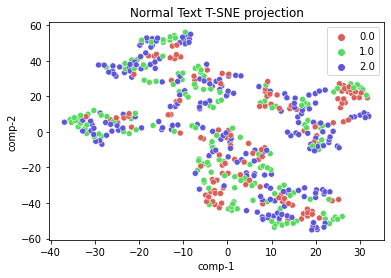

In [81]:
#norm text
x = X_val_text[11300:]
y = y_val_text[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Normal Text T-SNE projection") 

# transformer feature

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.630162
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.400627
[t-SNE] KL divergence after 5000 iterations: 0.276762


[Text(0.5, 1.0, 'Normal EEG T-SNE projection')]

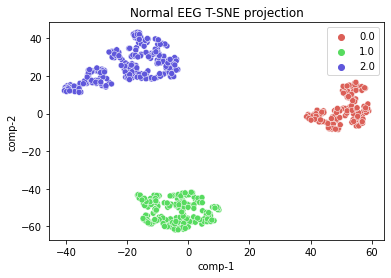

In [88]:
#norm eeg
x = X_val_eeg[11300:]
y = y_val_eeg[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Normal EEG T-SNE projection") 

# Fusion

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.195209
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.257481
[t-SNE] KL divergence after 5000 iterations: 0.284658


[Text(0.5, 1.0, 'Fusion T-SNE projection')]

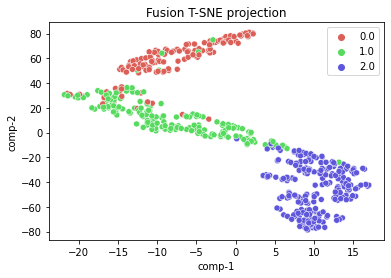

In [80]:
#fusion
x = X_val_fusion[11300:]
y = y_val_fusion[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Fusion T-SNE projection") 

# DCCA

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.360759
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.524109
[t-SNE] KL divergence after 5000 iterations: 0.234279


[Text(0.5, 1.0, 'DCCA Fusion T-SNE projection')]

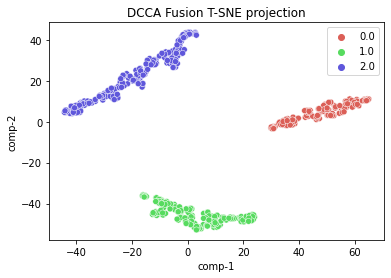

In [60]:
#DCCA Fusion
x = X_val_DCCA_fusion[11300:]
y = y_val_DCCA_fusion[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="DCCA Fusion T-SNE projection") 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.589679
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.111267
[t-SNE] KL divergence after 1350 iterations: 0.501792


[Text(0.5, 1.0, 'DCCA DS Text T-SNE projection')]

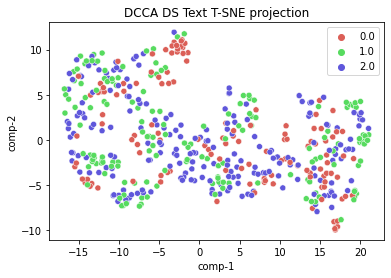

In [98]:
#DCCA DS
x = X_val_DCCA_ds_text[11300:]
y = y_val_DCCA_ds_text[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 50, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="DCCA DS Text T-SNE projection") 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.317136
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.382866
[t-SNE] KL divergence after 5000 iterations: 0.287950


[Text(0.5, 1.0, 'DCCA DS EEG T-SNE projection')]

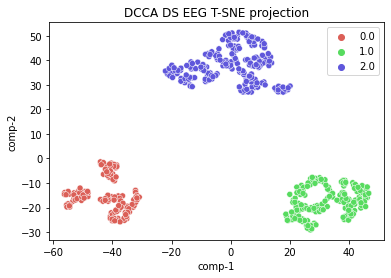

In [58]:
#DCCA DS
x = X_val_DCCA_ds_eeg[11300:]
y = y_val_DCCA_ds_eeg[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="DCCA DS EEG T-SNE projection") 

# WD

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.740640
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.200447
[t-SNE] KL divergence after 5000 iterations: 0.320024


[Text(0.5, 1.0, 'WD Fusion T-SNE projection')]

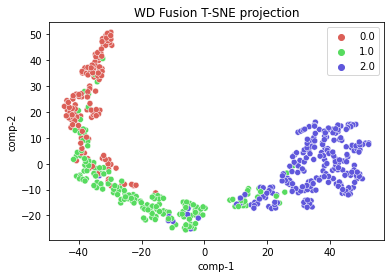

In [89]:
#WD Fusion
x = X_val_WD_fusion[11300:]
y = y_val_WD_fusion[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="WD Fusion T-SNE projection") 

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 500 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.267925
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.127636
[t-SNE] KL divergence after 5000 iterations: 0.416911


[Text(0.5, 1.0, 'WD Text T-SNE projection')]

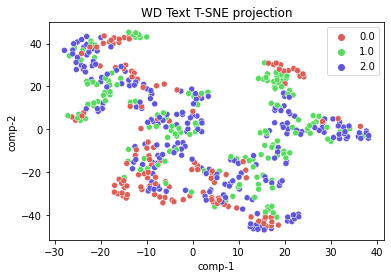

In [90]:
#WD DS
x = X_val_WD_ds_text[11300:]
y = y_val_WD_ds_text[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="WD Text T-SNE projection") 

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 500 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.226343
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.232285
[t-SNE] KL divergence after 5000 iterations: 0.268004


[Text(0.5, 1.0, 'WD EEG T-SNE projection')]

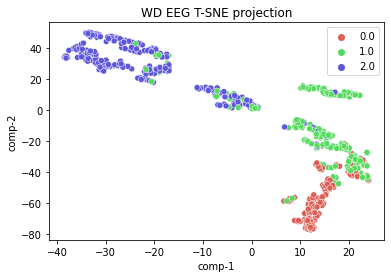

In [91]:
#WD DS
x = X_val_WD_ds_eeg[11300:]
y = y_val_WD_ds_eeg[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="WD EEG T-SNE projection") 

# Cossim

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 500 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.614231
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.376907
[t-SNE] KL divergence after 5000 iterations: 0.264177


[Text(0.5, 1.0, 'Cossim Fusion T-SNE projection')]

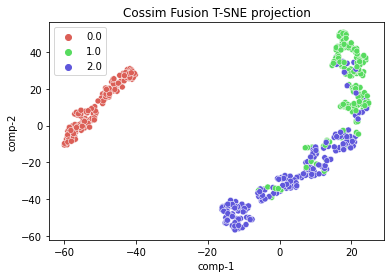

In [92]:
#Cossim fusion
x = X_val_CS_fusion[11300:]
y = y_val_CS_fusion[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Cossim Fusion T-SNE projection") 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.253361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.698616
[t-SNE] KL divergence after 4650 iterations: 0.567868


[Text(0.5, 1.0, 'Cossim Text T-SNE projection')]

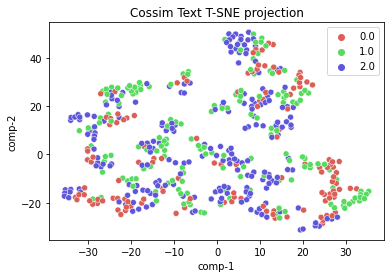

In [93]:
#Cossim DS
x = X_val_CS_ds_text[11300:]
y = y_val_CS_ds_text[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Cossim Text T-SNE projection") 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.980629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.831879
[t-SNE] KL divergence after 4850 iterations: 0.248575


[Text(0.5, 1.0, 'Cossim EEG T-SNE projection')]

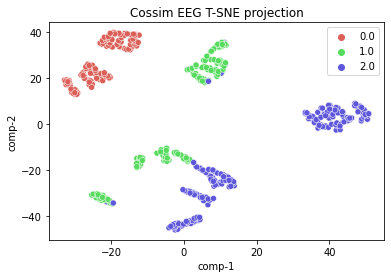

In [103]:
#Cossim DS
x = X_val_CS_ds_eeg[11300:]
y = y_val_CS_ds_eeg[11300:]

tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 20, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 
df = pd.DataFrame()

df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Cossim EEG T-SNE projection") 

# KEMOCON